In [1]:
import sys
try:
    sys.path.remove('/home/adun6414/JModelica/v2_0/JModelica/Python')
    sys.path.append('/home/adun6414/Downloads/PyFMI') # !!!!
except:
    
    print(sys.path)
    
import pyfmi
from pandas import *
from H_utility import *
import numpy as np
from numpy import *
import matplotlib.pyplot as mp
import time
from scipy.linalg import block_diag
import scipy as sp
from H_blkdiag import H_blkdiag
import PnP_subfunc
from PnP_subfunc import H_vec
import scipy as sp
import scipy.interpolate
import control.matlab as ctool
from H_simobj import H_simobj
import os

## a week solar data retrieved from a NOAA forcast


144

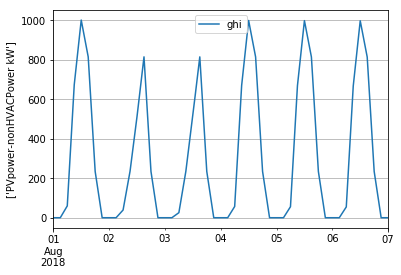

In [2]:
solar=np.array([0,0,59.7922975722,673.3856791513,1000.3938231115,814.2297872617,233.8892422495,0,0,0,38.937374863,235.2429832333,512.3358583589,814.1154122081,234.0855797133,0,0,0,25.4914434112,234.7922411414,518.4572768085,813.9719453969,234.2179083847,0,0,0,56.7522014546,669.5233740868,998.2175375163,813.7983209437,234.2848622366,0,0,0,55.6652715261,668.1891079735,997.4694559837,813.5935023605,234.285175578,0,0,0,54.5449832816,666.8332247361,996.7100180211,813.3564943995,234.2177007405,0,0])
dumN=solar.size
solartime=np.arange(0,dumN)*3*3600 # 3 hour interval solar data
assert(dumN==solartime.size)
df=DataFrame(solar,columns=['ghi'])
df.index=H_simtime2date(solartime,'2018-08-01 00:00')
df=df['2018-08-01 00:00':'2018-08-07 00:00'].resample('60T').interpolate() #Filling in NaN in a Series via linear interpolation.
df.plot(grid=True)
ylabel(['PVpower-nonHVACPower kW'])

Qsol=df['ghi'].iloc[:-1].to_numpy()*2 # Assuming there is 2 MW (PVpower-nonHVACpower)
Qsol.size


## key variables setup according to modelica model and prepare Measured disturbances 

In [3]:
currentdir='/home/adun6414/Work/CERC_UCM'
os.chdir(currentdir)


# configuration
dt=60*60; # 60 min sampling time
start_time=H_date2simtime(to_datetime('2018-08-01 00:00'),'2018')
final_time=H_date2simtime(to_datetime('2018-08-06 23:45'),'2018')
simtimes=arange(start_time,final_time,dt)
simtimedate=date_range(start=H_simtime2date(start_time,'2018'),end=H_simtime2date(final_time,'2018'),freq=str(int(dt*1./60))+'T')

key_x='H_par_x0'
x0_val=0.6; # initial state of charge
# inputs (controllable variables)
key_u=['ChillerON','SP_mCH', 'TCHeSP']
# inputs: disturbance
key_w=['BuildingCoolingLoads', 'ER', 'PnonHVAC', 'Psolarpv']
# outputs of interests
key_y=['Output[1]','Output[2]','Output[3]','Output[4]','Sensor_TCHWS.T','Sensor_TCHWR.T',
       'Sensor_msup.m_flow','Sensor_mCHi.m_flow','Sensor_mS.m_flow','time',
      'Sensor_Tstorage[1].y','Sensor_Tstorage[2].y','Sensor_Height[1]','Sensor_Height[2]','Sensor_Height[3]']

testcase=2
if testcase==1:
    modelname='Merced.CoolingPlantNew.Chiller_Storage_Only_V2_MPC'
    modelicafile='/home/adun6414/Work/CERC_UCM/Merced/CoolingPlantNew/Chiller_Storage_Only_V2_MPC.mo'
elif testcase==2:
    modelname='Merced.CoolingPlantNew.Chiller_Storage_CoolingTower_V2_MPC'
    modelicafile='/home/adun6414/Work/CERC_UCM/Merced/CoolingPlantNew/Chiller_Storage_CoolingTower_V2_MPC.mo'

idmodel=list() # not used for UC-Merced

#% data loading and resampling
os.chdir('/home/adun6414/Work/CERC_UCM/Fig_n_data')
filename='DATA8to8.csv' #filename='DATA8to9.csv'
DATARAW=read_csv(filename).set_index('Date')
DATARAW=DATARAW.set_index(to_datetime(DATARAW.index)) # change 'str' to datetime obj
DATARAW['time']=H_date2simtime(DATARAW.index,'2018')
dummy=DATARAW.reindex(simtimedate,method='nearest') # resample or reindex
DATA=dummy[['time','QBL','Twb','QCHLsum','z']].fillna(method='ffill')
DATA['Pow']=dummy[['PCHsum','PCTtot']].sum(axis=1)
del DATARAW, dummy
os.chdir(currentdir)

#% specify disturbances
t_schedule=simtimes

CHON=H_schedule(t_schedule,array([7,19]),1,1)
mEva_flow_nominal=gpm2kgs(3000);#obj.fmuinpy.get('mEva_flow_nominal')
SP_mCH=H_schedule(t_schedule,array([7,19]),0.*mEva_flow_nominal,0.9*mEva_flow_nominal)
TCHeSP=H_schedule(t_schedule,array([7,19]),4,4) # C
QBL=H_iscolumn(DATA['QBL'].to_numpy()) # kW
ER=H_schedule(t_schedule,array([7,19]),2,1) #$/kWh
PnonHVAC=filtfilt(3,H_schedule(t_schedule,[7,19],0*1000,0)) # kW
Psolarpv=H_iscolumn(Qsol) #filtfilt(3,H_schedule(t_schedule,[7,19],0*1000,0)) # kW
          
u=hstack((CHON,SP_mCH,TCHeSP))
w=hstack((QBL,ER,PnonHVAC,Psolarpv))

schedule={'u': u, 'w': w, 't': H_iscolumn(t_schedule)}
obj=H_simobj(dt=dt,start_time=start_time,final_time=final_time,modelname=modelname,modelicafile=modelicafile,
             fmu='./Merced_CoolingPlantNew_Chiller_Storage_CoolingTower_V2_MPC.fmu',
             idmodel=idmodel,key_u=key_u,key_w=key_w,key_y=key_y,key_x=key_x,schedule=schedule)
   
#(res,IN0)=obj.simulate_schedule(x0_val,schedule,wannaplot=True)
# conventional control simulation
from H_DP_Merced_Simple import *
obj.Ctrlsetup(Convobj=H_Conv_Merced_Simple,MPCobj=H_DP_Merced_Simple,Npday=2)



## Simulate Conventional Control
- and save the data in obj.DATA[0]


Could not find GLIMDA.


Final Run Statistics: --- 

 Number of steps                                 : 631
 Number of function evaluations                  : 683
 Number of Jacobian evaluations                  : 13
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 4
 Number of nonlinear iterations                  : 673
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 644
 Number of state events                          : 2

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18316800.0 - 18320400.0 seconds.
Elapsed simulation time: 0.13432805400225334 

Final Run Statistics: --- 

 Number of steps                                 : 1037
 Number of function evaluations                  : 1395
 Number of Jacobian evaluations                  : 32
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 36
 Number of nonlinear iterations                  : 1295
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 1251
 Number of state events                          : 24

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18349200.0 - 18352800.0 seconds.
Elapsed simulation time: 0.201005356000

Final Run Statistics: --- 

 Number of steps                                 : 1125
 Number of function evaluations                  : 1494
 Number of Jacobian evaluations                  : 34
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 34
 Number of nonlinear iterations                  : 1382
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 1332
 Number of state events                          : 27

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18381600.0 - 18385200.0 seconds.
Elapsed simulation time: 0.218537613996

Final Run Statistics: --- 

 Number of steps                                 : 502
 Number of function evaluations                  : 507
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 503
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 503

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18414000.0 - 18417600.0 seconds.
Elapsed simulation time: 0.12053818399726879 seconds.
Final Run Statistics: --- 

 Number of steps 

Final Run Statistics: --- 

 Number of steps                                 : 1112
 Number of function evaluations                  : 1478
 Number of Jacobian evaluations                  : 34
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 35
 Number of nonlinear iterations                  : 1366
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 1311
 Number of state events                          : 27

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18446400.0 - 18450000.0 seconds.
Elapsed simulation time: 0.227579454003

Final Run Statistics: --- 

 Number of steps                                 : 506
 Number of function evaluations                  : 512
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 508
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 507

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18478800.0 - 18482400.0 seconds.
Elapsed simulation time: 0.12197340300190262 seconds.
Final Run Statistics: --- 

 Number of steps 

Final Run Statistics: --- 

 Number of steps                                 : 503
 Number of function evaluations                  : 510
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 506
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 504

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18514800.0 - 18518400.0 seconds.
Elapsed simulation time: 0.11915736600349192 seconds.
Final Run Statistics: --- 

 Number of steps 

Final Run Statistics: --- 

 Number of steps                                 : 1127
 Number of function evaluations                  : 1501
 Number of Jacobian evaluations                  : 35
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 35
 Number of nonlinear iterations                  : 1385
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 1340
 Number of state events                          : 28

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18547200.0 - 18550800.0 seconds.
Elapsed simulation time: 0.222464641999

Final Run Statistics: --- 

 Number of steps                                 : 503
 Number of function evaluations                  : 508
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 504
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 504

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18583200.0 - 18586800.0 seconds.
Elapsed simulation time: 0.12055241900088731 seconds.
Final Run Statistics: --- 

 Number of steps 

Final Run Statistics: --- 

 Number of steps                                 : 1042
 Number of function evaluations                  : 1364
 Number of Jacobian evaluations                  : 31
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 30
 Number of nonlinear iterations                  : 1264
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 1216
 Number of state events                          : 24

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18615600.0 - 18619200.0 seconds.
Elapsed simulation time: 0.208267278998

Final Run Statistics: --- 

 Number of steps                                 : 503
 Number of function evaluations                  : 509
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 505
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 504

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18651600.0 - 18655200.0 seconds.
Elapsed simulation time: 0.11976078400039114 seconds.
Final Run Statistics: --- 

 Number of steps 

Final Run Statistics: --- 

 Number of steps                                 : 502
 Number of function evaluations                  : 508
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 504
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 503

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18687600.0 - 18691200.0 seconds.
Elapsed simulation time: 0.12054465900291689 seconds.
Final Run Statistics: --- 

 Number of steps 

Final Run Statistics: --- 

 Number of steps                                 : 1127
 Number of function evaluations                  : 1502
 Number of Jacobian evaluations                  : 35
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 35
 Number of nonlinear iterations                  : 1386
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 1342
 Number of state events                          : 28

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18720000.0 - 18723600.0 seconds.
Elapsed simulation time: 0.257712196005

Final Run Statistics: --- 

 Number of steps                                 : 500
 Number of function evaluations                  : 504
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 500
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 501

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18752400.0 - 18756000.0 seconds.
Elapsed simulation time: 0.11944981800479582 seconds.
Final Run Statistics: --- 

 Number of steps 

Final Run Statistics: --- 

 Number of steps                                 : 1139
 Number of function evaluations                  : 1514
 Number of Jacobian evaluations                  : 35
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 35
 Number of nonlinear iterations                  : 1398
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 1351
 Number of state events                          : 28

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18784800.0 - 18788400.0 seconds.
Elapsed simulation time: 0.241551745995

Final Run Statistics: --- 

 Number of steps                                 : 1126
 Number of function evaluations                  : 1495
 Number of Jacobian evaluations                  : 34
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 34
 Number of nonlinear iterations                  : 1383
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 1330
 Number of state events                          : 27

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18817200.0 - 18820800.0 seconds.
Elapsed simulation time: 0.247733358999

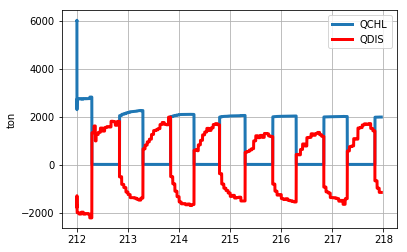

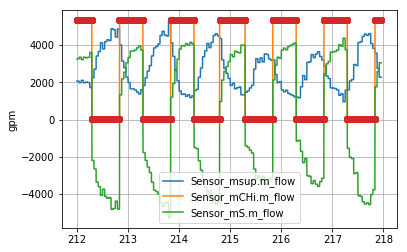

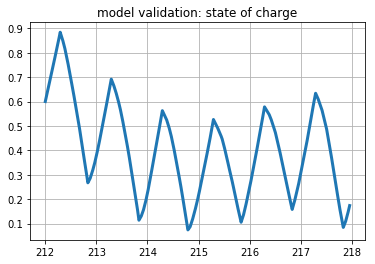

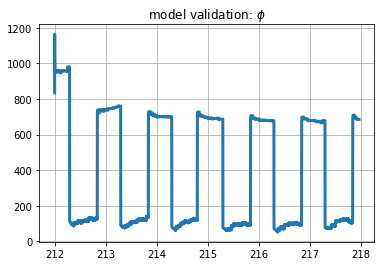

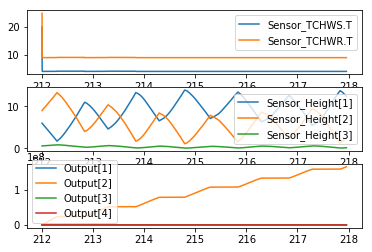

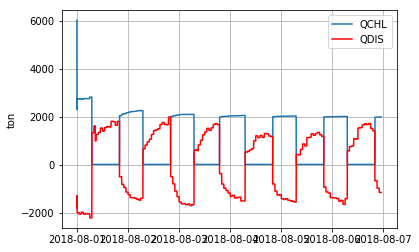

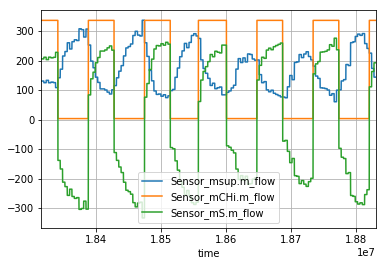

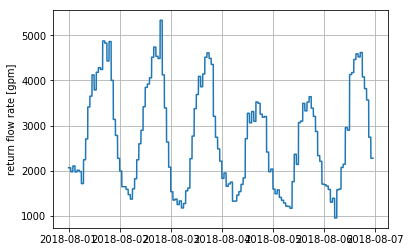

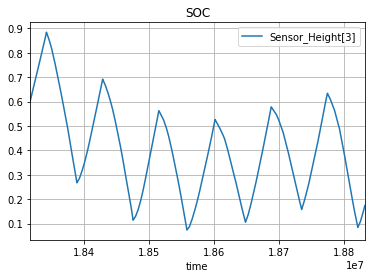

In [4]:
obj.evaluate_Ctrl(x0_val,control='Conv')
res=obj.analysis_performance(control='Conv')
data=DataFrame(columns=obj.key_u+obj.key_y+obj.key_w)  
for k in obj.key_u+obj.key_y+obj.key_w:
    data[k]=res[k]
data.index=data.time
figure(100)
plot(to_datetime(H_simtime2date(data['time'],'2018')),kW2ton(data['Output[3]']))     
plot(to_datetime(H_simtime2date(data['time'],'2018')),kW2ton(data['Output[4]']),'r')
legend(['QCHL','QDIS'])
ylabel('ton')
grid(True)

data.plot(x='time',y=[k for k in obj.key_y if '.m_flow' in k])
grid(True)

figure(102)
plot(to_datetime(H_simtime2date(data['time'],'2018')),data['Sensor_msup.m_flow'].apply(kgs2gpm))
ylabel('return flow rate [gpm]')
grid(True)

data.plot(x='time',y=[k for k in obj.key_y if 'Height[3]' in k])    
title('SOC')
grid(True)


## Perform One-shot MPC and Feed it to Modelica Model to see 
- 1. MPC makes sense
- 2. The local controllers follows my decision. 

In Bellam,  Np: 48 W: (48, 4)
(48, 1)
Final Run Statistics: --- 

 Number of steps                                 : 48803
 Number of function evaluations                  : 75846
 Number of Jacobian evaluations                  : 1676
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 3439
 Number of nonlinear iterations                  : 69372
 Number of nonlinear convergence failures        : 7
 Number of state function evaluations            : 61459
 Number of state events                          : 1618

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-04 3.e-04 1.e+00]
 Tolerances (relative)    : 0.0001

Simulation interval    : 18316800.0 - 18486000.0 

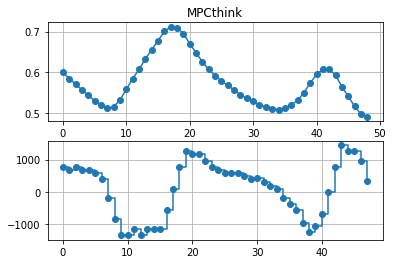

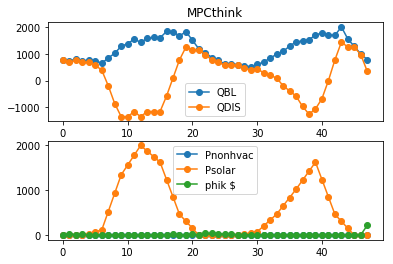

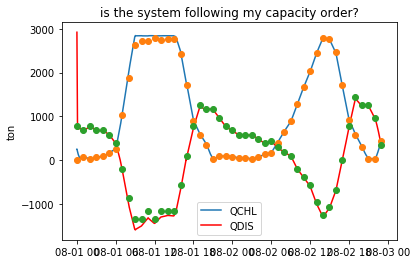

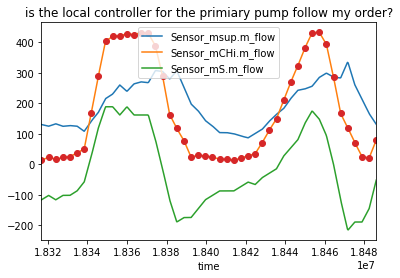

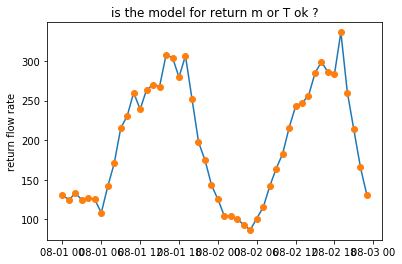

<Figure size 432x288 with 0 Axes>

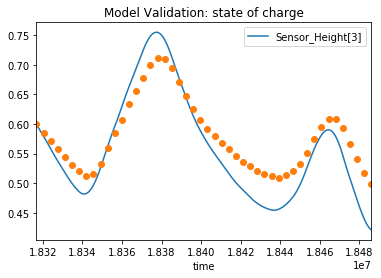

<Figure size 432x288 with 0 Axes>

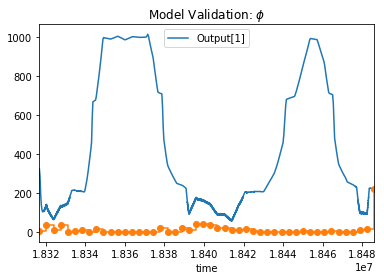

In [5]:
#%% MPC evaulation inputs: starts, final time, IC
obj.does_local_follow_mpc(x0_val)

## Iterate MPC and store data in obj.DATA[1]

In [6]:
#%% MPC evaulation inputs: starts, final time, IC
obj.evaluate_Ctrl(x0_val,control='MPC')

Np adjusted: 48
In Bellam,  Np: 48 W: (48, 4)
        cur_t          Uop         x        phi
0  18316800.0  2716.720048  0.600000   3.320982
1  18316800.0  2377.174003  0.585110  34.862751
2  18316800.0  2716.720048  0.572081  10.643483
u*: [ 1.         14.04375615  9.05032125]
x: 0.6
Final Run Statistics: --- 

 Number of steps                                 : 1324
 Number of function evaluations                  : 1805
 Number of Jacobian evaluations                  : 37
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 58
 Number of nonlinear iterations                  : 1687
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 1537
 Number of state events                          : 29

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerance

        cur_t          Uop         x       phi
0  18342000.0  -679.443776  0.468711   0.00000
1  18342000.0 -3056.266093  0.472435  21.77184
2  18342000.0 -4753.996320  0.489186   0.00000
u*: [  1.         168.57383556   4.37335906]
x: [[0.46871063]]
Final Run Statistics: --- 

 Number of steps                                 : 514
 Number of function evaluations                  : 521
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 517
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 515

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01

        cur_t          Uop         x  phi
0  18367200.0 -4074.904229  0.667857  0.0
1  18367200.0 -4074.904229  0.690191  0.0
2  18367200.0 -2037.627957  0.712526  0.0
u*: [  1.         431.93341381   4.27805815]
x: [[0.66785708]]
Final Run Statistics: --- 

 Number of steps                                 : 508
 Number of function evaluations                  : 516
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 512
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 509

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-0

        cur_t          Uop         x        phi
0  18392400.0  4074.904229  0.649003  11.545656
1  18392400.0  3395.812139  0.626669  41.415738
2  18392400.0  2716.720048  0.608057  42.519240
u*: [ 1.         23.25285783  8.61690058]
x: [[0.64900327]]
Final Run Statistics: --- 

 Number of steps                                 : 3261
 Number of function evaluations                  : 5072
 Number of Jacobian evaluations                  : 111
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 235
 Number of nonlinear iterations                  : 4636
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 4057
 Number of state events                          : 108

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01

        cur_t          Uop         x        phi
0  18417600.0  1698.081912  0.495370  10.290252
1  18417600.0  1358.535867  0.486063  13.832713
2  18417600.0  1358.535867  0.478617  30.876166
u*: [ 1.         20.16893825  6.4490379 ]
x: [[0.49537022]]
Final Run Statistics: --- 

 Number of steps                                 : 2932
 Number of function evaluations                  : 4444
 Number of Jacobian evaluations                  : 94
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 199
 Number of nonlinear iterations                  : 4068
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 3612
 Number of state events                          : 93

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1

        cur_t          Uop         x       phi
0  18442800.0 -1358.535867  0.450254  2.008395
1  18442800.0 -2037.627957  0.457700  0.000000
2  18442800.0 -3395.812139  0.468869  2.486047
u*: [  1.         269.53374621   4.35554994]
x: [[0.45025441]]
Final Run Statistics: --- 

 Number of steps                                 : 512
 Number of function evaluations                  : 520
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 516
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 513

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01

        cur_t          Uop         x        phi
0  18468000.0  2716.720048  0.582157   0.000000
1  18468000.0  4753.996320  0.567267  35.961731
2  18468000.0  4074.904229  0.541211  42.257886
u*: [  1.         166.59503212   4.83271419]
x: [[0.58215736]]
Final Run Statistics: --- 

 Number of steps                                 : 513
 Number of function evaluations                  : 521
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 517
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 514

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.

        cur_t          Uop         x        phi
0  18493200.0  1698.081912  0.386630  13.205218
1  18493200.0  1698.081912  0.377323  17.156361
2  18493200.0  1358.535867  0.368016  43.084287
u*: [ 1.         12.48784372  7.68203475]
x: [[0.38662991]]
Final Run Statistics: --- 

 Number of steps                                 : 2347
 Number of function evaluations                  : 3672
 Number of Jacobian evaluations                  : 84
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 185
 Number of nonlinear iterations                  : 3364
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 2904
 Number of state events                          : 76

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1

        cur_t          Uop         x        phi
0  18518400.0    -0.351685  0.305614   0.000000
1  18518400.0  -339.897731  0.305616  16.588976
2  18518400.0 -1018.989821  0.307479  21.591915
u*: [  1.         102.14649607   4.44438372]
x: [[0.30561383]]
Final Run Statistics: --- 

 Number of steps                                 : 507
 Number of function evaluations                  : 513
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 509
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 508

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.

        cur_t          Uop         x       phi
0  18543600.0 -4074.904229  0.401317  0.000000
1  18543600.0 -2716.720048  0.423652  1.843029
2  18543600.0   339.897731  0.438542  0.000000
u*: [  1.         423.03351004   4.27455767]
x: [[0.40131732]]
Final Run Statistics: --- 

 Number of steps                                 : 508
 Number of function evaluations                  : 514
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 510
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 509

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01

        cur_t          Uop         x        phi
0  18568800.0  3056.266093  0.344104  33.602430
1  18568800.0  2716.720048  0.327353  30.723513
2  18568800.0  2377.174003  0.312463   7.221178
u*: [ 1.         25.75445804  7.26990636]
x: [[0.34410425]]
Final Run Statistics: --- 

 Number of steps                                 : 3501
 Number of function evaluations                  : 5611
 Number of Jacobian evaluations                  : 113
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 308
 Number of nonlinear iterations                  : 5159
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 4301
 Number of state events                          : 112

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01

        cur_t          Uop         x  phi
0  18594000.0  1358.535867  0.207229  0.0
1  18594000.0  1018.989821  0.199783  0.0
2  18594000.0 -1698.081912  0.194198  0.0
u*: [ 1.         25.51367111  5.71223895]
x: [[0.20722896]]
Final Run Statistics: --- 

 Number of steps                                 : 1839
 Number of function evaluations                  : 2741
 Number of Jacobian evaluations                  : 51
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 119
 Number of nonlinear iterations                  : 2537
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 2225
 Number of state events                          : 50

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-

        cur_t          Uop         x  phi
0  18619200.0 -5433.088411  0.389400  0.0
1  18619200.0 -5772.634456  0.419178  0.0
2  18619200.0 -5433.088411  0.450817  0.0
u*: [  1.         422.07514532   4.21741931]
x: [[0.38939963]]
Final Run Statistics: --- 

 Number of steps                                 : 510
 Number of function evaluations                  : 518
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 514
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 511

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-0

        cur_t          Uop         x        phi
0  18644400.0  2037.627957  0.582541   0.000000
1  18644400.0  3395.812139  0.571373   0.000000
2  18644400.0  3056.266093  0.552760  20.352905
u*: [  1.         113.7041812    4.87112138]
x: [[0.58254081]]
Final Run Statistics: --- 

 Number of steps                                 : 508
 Number of function evaluations                  : 515
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 511
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 509

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.

        cur_t          Uop         x        phi
0  18669600.0  2037.627957  0.442873   7.353958
1  18669600.0  1698.081912  0.431704  24.528001
2  18669600.0  1698.081912  0.422397   0.000000
u*: [ 1.         12.15430963  8.43602873]
x: [[0.44287257]]
Final Run Statistics: --- 

 Number of steps                                 : 2253
 Number of function evaluations                  : 3515
 Number of Jacobian evaluations                  : 77
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 172
 Number of nonlinear iterations                  : 3215
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 2809
 Number of state events                          : 74

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1

        cur_t          Uop         x  phi
0  18694800.0 -6791.272592  0.427761  0.0
1  18694800.0 -6451.726547  0.464983  0.0
2  18694800.0 -6791.272592  0.500345  0.0
u*: [  1.         380.50630355   4.12966508]
x: [[0.42776079]]
Final Run Statistics: --- 

 Number of steps                                 : 521
 Number of function evaluations                  : 530
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 526
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 522

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-0

        cur_t          Uop         x  phi
0  18720000.0 -3735.358184  0.745867  0.0
1  18720000.0 -1018.989821  0.766340  0.0
2  18720000.0  1358.535867  0.771925  0.0
u*: [  1.         370.33627813   4.26655387]
x: [[0.74586664]]
Final Run Statistics: --- 

 Number of steps                                 : 516
 Number of function evaluations                  : 526
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 522
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 517

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-0

        cur_t          Uop         x        phi
0  18745200.0  2037.627957  0.681516  31.692008
1  18745200.0  2037.627957  0.670348  28.876734
2  18745200.0  2037.627957  0.659180  23.305021
u*: [ 1.         20.26699285  6.83823575]
x: [[0.68151601]]
Final Run Statistics: --- 

 Number of steps                                 : 3053
 Number of function evaluations                  : 4809
 Number of Jacobian evaluations                  : 97
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 248
 Number of nonlinear iterations                  : 4421
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 3762
 Number of state events                          : 96

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1

        cur_t          Uop         x        phi
0  18770400.0  1200.868852  0.583742  18.297230
1  18770400.0 -1358.535867  0.577160   0.000000
2  18770400.0 -3735.358184  0.584606   1.494824
u*: [ 1.         48.18082197  5.03787798]
x: [[0.58374217]]
Final Run Statistics: --- 

 Number of steps                                 : 1346
 Number of function evaluations                  : 2149
 Number of Jacobian evaluations                  : 77
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 79
 Number of nonlinear iterations                  : 1841
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 1968
 Number of state events                          : 76

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.

        cur_t          Uop         x  phi
0  18795600.0 -4074.904229  0.780766  0.0
1  18795600.0 -3735.358184  0.803101  0.0
2  18795600.0 -3735.358184  0.823574  0.0
u*: [  1.         425.09182539   4.27538027]
x: [[0.78076633]]
Final Run Statistics: --- 

 Number of steps                                 : 505
 Number of function evaluations                  : 512
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 508
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 506

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-01 1.e-06 1.e-06 1.e-0

        cur_t          Uop         x        phi
0  18820800.0  3733.739979  0.844696   0.000000
1  18820800.0  3395.812139  0.824232  34.212750
2  18820800.0  2716.720048  0.805620  43.011173
u*: [ 1.         65.01506138  5.81179793]
x: [[0.84469612]]
Final Run Statistics: --- 

 Number of steps                                 : 508
 Number of function evaluations                  : 516
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 512
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 509

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [1.e-01 1.e-01 1.e-01 1.e-06 1.e-06 1.e-01 1.e-01 1.e-01 1.e-01 1.e-01
 1.e-0

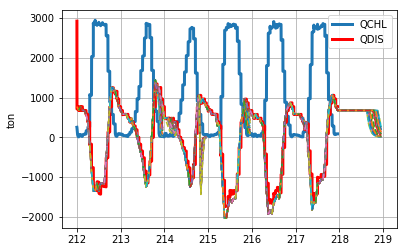

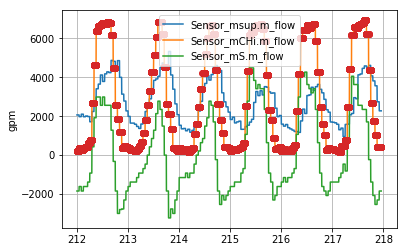

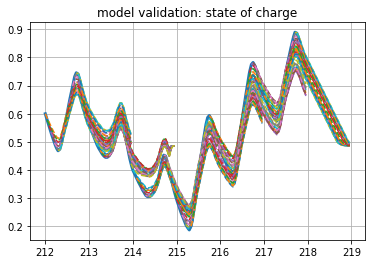

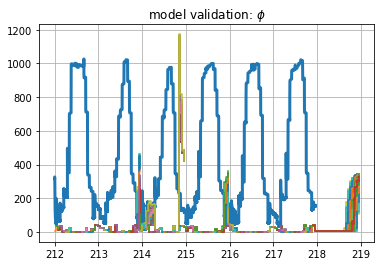

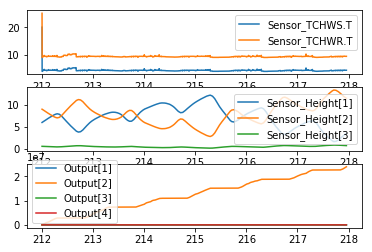

In [7]:
obj.analysis_performance(control='MPC')
obj.fmuinpy.print_log()

## Comparisons between MPC & Conventional

Index(['time', 'QBL', 'Twb', 'QCHLsum', 'z', 'Pow'], dtype='object')


(3, 7)

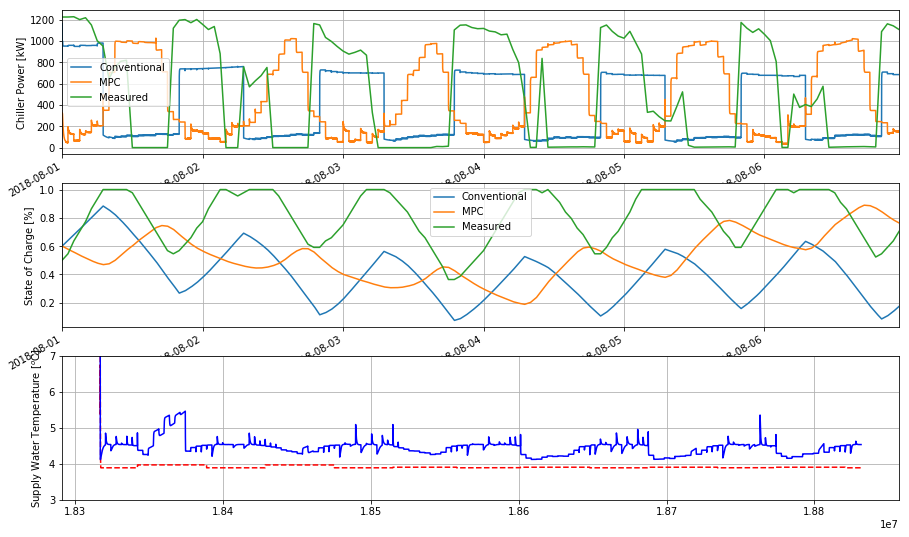

In [14]:
for j in range(2):
    obj.DATA[j].index=H_simtime2date(obj.DATA[j].time,'2018')

figure(figsize=(15,10))
ax=subplot(3,1,1)
obj.DATA[0]['Output[1]'].plot(ax=ax)
obj.DATA[1]['Output[1]'].plot(ax=ax)
DATA['Pow']['2018-08-01 00:00':'2018-08-07 00:00'].plot(ax=ax)
print(DATA.columns)
grid(True)
legend(['Conventional', 'MPC','Measured'])
ylabel('Chiller Power [kW]')

ax=subplot(3,1,2)
obj.DATA[0]['Sensor_Height[3]'].plot(ax=ax)
obj.DATA[1]['Sensor_Height[3]'].plot(ax=ax)
(DATA['z']['2018-08-01 00:00':'2018-08-07 00:00']/100).plot(ax=ax)
legend(['Conventional', 'MPC','Measured'])
ylabel('State of Charge [%]')
grid(True)

ax=subplot(3,1,3)
plot(obj.DATA[0].time.to_numpy(),obj.DATA[0]['Sensor_TCHWS.T']-273.15,'r--')
plot(obj.DATA[1].time.to_numpy(),obj.DATA[1]['Sensor_TCHWS.T']-273.15,'b')
ylabel('Supply Water Temperature [$^o$C]')
grid(True)
ylim([3,7])

Text(0, 0.5, ' Net Power Consumption [kW]')

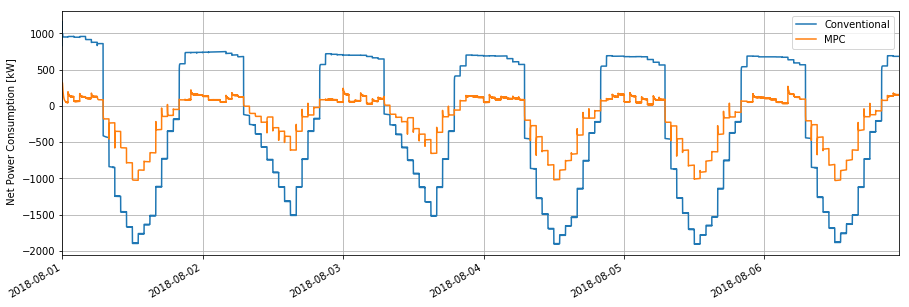

In [9]:
NetPowConsumption_Conv=obj.DATA[0]['Output[1]']-obj.DATA[0]['Psolarpv']
NetPowConsumption_MPC =obj.DATA[1]['Output[1]']-obj.DATA[1]['Psolarpv']
figure(figsize=(15,5))
NetPowConsumption_Conv.plot()
NetPowConsumption_MPC.plot()
grid(True)
legend(['Conventional', 'MPC'])
ylabel(' Net Power Consumption [kW]')
#Grid True
#obj.DATA[0].columns

(0, 3000)

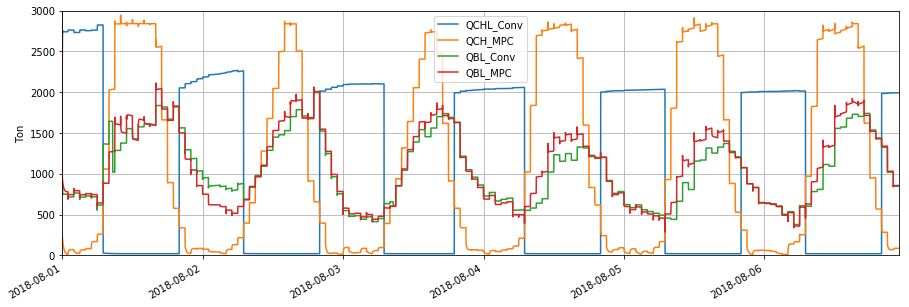

In [10]:
QCHL_Conv=obj.DATA[0]['Output[3]'].apply(kW2ton)
QCHL_MPC =obj.DATA[1]['Output[3]'].apply(kW2ton)
QDIS_Conv=obj.DATA[0]['Output[4]'].apply(kW2ton)
QDIS_MPC =obj.DATA[1]['Output[4]'].apply(kW2ton)

QBL_Conv=QCHL_Conv+QDIS_Conv
QBL_MPC=QCHL_MPC+QDIS_MPC

figure(figsize=(15,5))
QCHL_Conv.plot()
QCHL_MPC.plot()
QBL_Conv.plot()
QBL_MPC.plot()
legend(['QCHL_Conv','QCH_MPC','QBL_Conv','QBL_MPC'])
ylabel('Ton')
grid(True)
ylim([0,3000])

